### Data 200 Graduate Project: 

# Greenhouse Gas Emissions Prediction of Stationary Emitters in the US

## Authors: Jazmyn Huang, Jiayin Guo



<h3> Import Statements

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import contextily as cx
import re
import os
from sklearn import linear_model as lm

## Part 1. Data Sampling and Collection

The data used is reported by EPA (Environment Protection Agency) on greenhouse gas emissions, detailing the specific types of gas reported by facilities and general information about the facilities themselves. The dataset is made available through EPA’s [GHGRP (Greenhouse Gas Reporting Program)](https://www.epa.gov/ghgreporting).

<h4>1.1 Import data</h4>

In [2]:
# import data
ghg_type = pd.read_csv("../data/us_greenhouse_gas_emission_direct_emitter_gas_type.csv")
ghg_facilities =  pd.read_csv("../data/us_greenhouse_gas_emissions_direct_emitter_facilities.csv")
naics = pd.read_excel('../data/2-6 digit_2017_Codes.xlsx',header=0)

/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


<h4>1.2 Inspect the "gas type" data</h4>

In [3]:
ghg_type.shape

(219928, 16)

In [4]:
ghg_type.head()

,V_GHG_EMITTER_GAS.ADDRESS1,V_GHG_EMITTER_GAS.ADDRESS2,V_GHG_EMITTER_GAS.CITY,V_GHG_EMITTER_GAS.CO2E_EMISSION,V_GHG_EMITTER_GAS.COUNTY,V_GHG_EMITTER_GAS.FACILITY_ID,V_GHG_EMITTER_GAS.GAS_CODE,V_GHG_EMITTER_GAS.GAS_NAME,V_GHG_EMITTER_GAS.LATITUDE,V_GHG_EMITTER_GAS.LONGITUDE,V_GHG_EMITTER_GAS.STATE,V_GHG_EMITTER_GAS.STATE_NAME,V_GHG_EMITTER_GAS.YEAR,V_GHG_EMITTER_GAS.ZIP,V_GHG_EMITTER_GAS.FACILITY_NAME,V_GHG_EMITTER_GAS.COUNTY_FIPS
0,1919 S. BROADWAY,NaN,GREEN BAY,58024.000,BROWN COUNTY,1000589,BIOCO2,Biogenic CO2,44.492500,-88.032300,WI,WISCONSIN,2017,54304,GEORGIA-PACIFIC CONSUMER OPERATIONS LLC,55009.0
1,850 12TH AVE,NaN,NEW YORK,134.500,New York,1000766,CH4,Methane,40.771100,-73.991100,NY,NEW YORK,2018,10019,59th Street,36061.0
2,3379 HWY 482,NaN,Noble,6.854,SABINE,1009343,N2O,Nitrous Oxide,31.621528,-93.724774,LA,LOUISIANA,2012,71462,Baker Road Treater,22085.0
3,1012 BEAUCHAMP ST,NaN,GREENVILLE,53562.000,WASHINGTON COUNTY,1003557,CH4,Methane,33.392476,-91.017584,MS,MISSISSIPPI,2017,38701,TEXAS GAS TRANSMISSION - GREENVILLE STATION,28151.0
4,487 CORN CREEK ROAD,NaN,BEDFORD,7635064.700,Trimble,1006542,CO2,Carbon Dioxide,38.584700,-85.411700,KY,KENTUCKY,2018,40006,Trimble County,21223.0


The "gas type" dataset containing over 200,000 observations for 16 features with every row representing the record of one "emitter", that is, one facility. The features provide information about the type of the gas the facilit emitted, as well as about the facility itself.
__For the modeling purpose, we are most interested in total CO<sub>2</sub> emission, emitter's state, emission year and (possibly) the emission gas type.__

<h4>1.3 Inspect the "facilities" data</h4>

In [5]:
ghg_facilities.shape

(77106, 21)

In [6]:
ghg_facilities.head()

,V_GHG_EMITTER_FACILITIES.ADDRESS1,V_GHG_EMITTER_FACILITIES.ADDRESS2,V_GHG_EMITTER_FACILITIES.CEMS_USED,V_GHG_EMITTER_FACILITIES.CITY,V_GHG_EMITTER_FACILITIES.COUNTY,V_GHG_EMITTER_FACILITIES.COUNTY_FIPS,V_GHG_EMITTER_FACILITIES.FACILITY_ID,V_GHG_EMITTER_FACILITIES.LATITUDE,V_GHG_EMITTER_FACILITIES.LONGITUDE,V_GHG_EMITTER_FACILITIES.PRIMARY_NAICS_CODE,...,V_GHG_EMITTER_FACILITIES.STATE_NAME,V_GHG_EMITTER_FACILITIES.YEAR,V_GHG_EMITTER_FACILITIES.ZIP,V_GHG_EMITTER_FACILITIES.FACILITY_NAME,V_GHG_EMITTER_FACILITIES.SECONDARY_NAICS_CODE,V_GHG_EMITTER_FACILITIES.ADDITIONAL_NAICS_CODES,V_GHG_EMITTER_FACILITIES.COGENERATION_UNIT_EMISS_IND,V_GHG_EMITTER_FACILITIES.EPA_VERIFIED,V_GHG_EMITTER_FACILITIES.PARENT_COMPANY,V_GHG_EMITTER_FACILITIES.PLANT_CODE_INDICATOR
0,301 Commerce Dr. Suite 3701,NaN,NaN,Fort Worth,NaN,NaN,1008536.0,35.533760,-97.529760,211111.0,...,TEXAS,2012.0,76102.0,TEP Barnett USA LLC 415 - Strawn Basin,NaN,NaN,N,NaN,CHESAPEAKE ENERGY CORP (100%),NaN
1,449 Shell E&P Court,NaN,NaN,Gibson,TERREBONNE,22109.0,1005071.0,29.628790,-90.917680,211112.0,...,LOUISIANA,2011.0,70358.0,North Terrebonne Gas Plant,NaN,NaN,N,NaN,ENTERPRISE GAS PROCESSING LLC (64.19%); DCP M...,NaN
2,5494 MALONE ROAD,NaN,NaN,MEMPHIS,SHELBY COUNTY,47157.0,1002466.0,34.999213,-89.906724,562212.0,...,TENNESSEE,2017.0,38116.0,SOUTH SHELBY LANDFILL,NaN,NaN,N,NaN,REPUBLIC SERVICES INC (100%),N
3,1601 WEEDON ISLAND DRIVE,NaN,NaN,SAINT PETERSBURG,Pinellas,12103.0,1001489.0,27.861300,-82.601200,221112.0,...,FLORIDA,2015.0,33702.0,P L Bartow Power Plant,NaN,NaN,N,NaN,DUKE ENERGY CORP (100%),Y
4,NaN,NaN,NaN,Rhome,WISE COUNTY,48497.0,1007509.0,33.052600,-97.411400,211112.0,...,TEXAS,2015.0,76078.0,Ross Compressor Station,NaN,NaN,N,NaN,SWG PIPELINE LLC (100%),Y


The "facility" dataset contaning over 77,106 observations for 21 features with every row representing the record of one facility. The features of this dataset concentrate on the emission facility itself, including information about whether the facility is EPA verified, the NAICS code of the facility and so on.

For our modeling porpuse, most of the information in this dataset will not be used (some of the features in this dataset are covered by the "gas type" dataset already). However, we are going to use the NAICS code to match the facility with the facility's industry type, which would be much more useful in predicting the total CO<sub>2</sub> emission.

<h4>1.4 Inspect the "naics" data</h4>

In [7]:
naics.shape

(2196, 2)

In [8]:
naics.head()

,2017 NAICS US Code,2017 NAICS US Title
0,11,"Agriculture, Forestry, Fishing and Hunting"
1,111,Crop Production
2,1111,Oilseed and Grain Farming
3,11111,Soybean Farming
4,111110,Soybean Farming


The "naics" data maps the [NAICS code](https://www.naics.com/what-is-a-naics-code-why-do-i-need-one/) to the NAICS title——basically the industry type——in America. It cantains 2,196 rows with each row being a distinct NAICS code and its corresponding industry. We are going to use this dataset to connet the facilities and its belonging industry for modeling purpose.

## Part 2. Data Cleaning

<h4>2.1 Clean the "gas type" data</h4>

The first step in data cleaning is to drop unnecessary features, rename the columns and unify text case.<br>
We can use the address information to abtain the geometry distribution of the facilities in U.S., but we only need latitude and lontitude data, the `V_GHG_EMITTER_GAS.ADDRESS2` contains address information in text type, which is not very useful here. The values in `V_GHG_EMITTER_GAS.STATE` column are all `NaN`, so we drop this column as well.

__The post-clean table is named as `ghg_type_clean`.__

In [9]:
# ghg_type formatting
ghg_type1 = ghg_type.copy()

# drop necessary columns (where all values are NaN or redundant content)
ghg_type1 = ghg_type1.drop(columns=['V_GHG_EMITTER_GAS.ADDRESS2','V_GHG_EMITTER_GAS.STATE'],axis=0) 

# rename columns
ghg_type1 = ghg_type1.rename(columns={'V_GHG_EMITTER_GAS.ADDRESS1':'gas_address',
                                      'V_GHG_EMITTER_GAS.CITY':'gas_city',
                                      'V_GHG_EMITTER_GAS.CO2E_EMISSION':'co2e_emission',
                                      'V_GHG_EMITTER_GAS.COUNTY':'gas_county',
                                      'V_GHG_EMITTER_GAS.FACILITY_ID':'facility_id',
                                      'V_GHG_EMITTER_GAS.GAS_CODE':'gas_code',
                                      'V_GHG_EMITTER_GAS.GAS_NAME':'gas_name',
                                      'V_GHG_EMITTER_GAS.LATITUDE':'gas_lat',
                                      'V_GHG_EMITTER_GAS.LONGITUDE':'gas_lng',
                                      'V_GHG_EMITTER_GAS.STATE_NAME':'gas_state',
                                      'V_GHG_EMITTER_GAS.YEAR':'gas_year',
                                      'V_GHG_EMITTER_GAS.COUNTY_FIPS':'gas_county_fips',
                                      'V_GHG_EMITTER_GAS.ZIP':'gas_zip',
                                      'V_GHG_EMITTER_GAS.FACILITY_NAME':'facility_name'})

# letters uppercase/lowercase
ghg_type1['gas_address'] = ghg_type1['gas_address'].str.upper()
ghg_type1['gas_city'] = ghg_type1['gas_city'].str.upper()
ghg_type1['gas_county'] = ghg_type1['gas_county'].str.upper()
ghg_type1['facility_name'] = ghg_type1['facility_name'].str.upper()

ghg_type1.head(3)

,gas_address,gas_city,co2e_emission,gas_county,facility_id,gas_code,gas_name,gas_lat,gas_lng,gas_state,gas_year,gas_zip,facility_name,gas_county_fips
0,1919 S. BROADWAY,GREEN BAY,58024.000,BROWN COUNTY,1000589,BIOCO2,Biogenic CO2,44.492500,-88.032300,WISCONSIN,2017,54304,GEORGIA-PACIFIC CONSUMER OPERATIONS LLC,55009.0
1,850 12TH AVE,NEW YORK,134.500,NEW YORK,1000766,CH4,Methane,40.771100,-73.991100,NEW YORK,2018,10019,59TH STREET,36061.0
2,3379 HWY 482,NOBLE,6.854,SABINE,1009343,N2O,Nitrous Oxide,31.621528,-93.724774,LOUISIANA,2012,71462,BAKER ROAD TREATER,22085.0




Since our modeling porpuse is to predicting the total CO<sub>2</sub> emission, it's important to clean the `co2e_emission` column. <br>
In the following process, we first remove the invalid values (those less than 0 and those that are missing data). It can be seen that the distribution of the total CO<sub>2</sub> emission data has a long right tail: most of the records contain a total CO<sub>2</sub> emission less than 20,000. One useful way to handle this property without spoiling useful information about outliers is that, we can apply log transformation on it. We will handle this later.

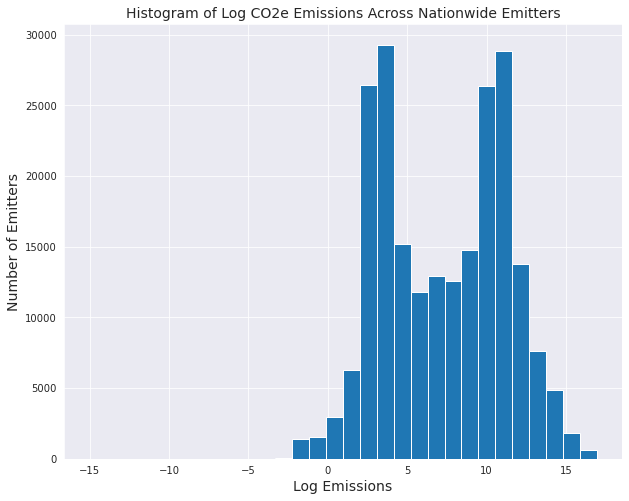

In [10]:
# co2e_emission: filter invalid values
sns.set_style("darkgrid")
ghg_type2 = ghg_type1[(ghg_type1['co2e_emission']>0) & (~ghg_type1['co2e_emission'].isna())]
plt.figure(figsize=(10,8))
plt.hist(np.log(ghg_type2['co2e_emission']),bins=30)
plt.title('Histogram of Log CO2e Emissions Across Nationwide Emitters', fontsize=14)
plt.xlabel('Log Emissions', fontsize=14)
plt.ylabel('Number of Emitters', fontsize=14)
plt.savefig('co2e log histogram.png')
ghg_type2['co2e_emission'].describe()
ghg_type_clean = ghg_type2

In [11]:
ghg_type_clean[(np.log(ghg_type1['co2e_emission'])>0)&(np.log(ghg_type1['co2e_emission'])<5)]

/opt/conda/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_270/377737551.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ghg_type_clean[(np.log(ghg_type1['co2e_emission'])>0)&(np.log(ghg_type1['co2e_emission'])<5)]


,gas_address,gas_city,co2e_emission,gas_county,facility_id,gas_code,gas_name,gas_lat,gas_lng,gas_state,gas_year,gas_zip,facility_name,gas_county_fips
1,850 12TH AVE,NEW YORK,134.500,NEW YORK,1000766,CH4,Methane,40.771100,-73.991100,NEW YORK,2018,10019,59TH STREET,36061.0
2,3379 HWY 482,NOBLE,6.854,SABINE,1009343,N2O,Nitrous Oxide,31.621528,-93.724774,LOUISIANA,2012,71462,BAKER ROAD TREATER,22085.0
5,384 OLD GRASSDALE RD NE,CARTERSVILLE,26.750,BARTOW COUNTY,1001103,CH4,Methane,34.242779,-84.797775,GEORGIA,2017,30121,GERDAU AMERISTEEL CARTERSVILLE STEEL MILL,13015.0
8,NaN,LUCEDALE,22.946,GEORGE COUNTY,1005332,N2O,Nitrous Oxide,30.972222,-88.699167,MISSISSIPPI,2014,39452,LUCEDALE (SESH) COMPRESSOR STATION,28039.0
9,666 SPRINGDALE RD,TARRANT,8.642,JEFFERSON COUNTY,1008249,N2O,Nitrous Oxide,33.593548,-86.769968,ALABAMA,2014,35217,SNG STATION 4152 TARRANT AL,1073.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219915,17045 GALEHOUSE RD,DOYLESTOWN,10.132,WAYNE COUNTY,1010623,N2O,Nitrous Oxide,40.942290,-81.681920,OHIO,2013,44230,DOMINION ENERGY OHIO - CHIPPEWA STATION (STOR),39169.0
219917,645 W. LAGUNA RD.,CAMARILLO,22.350,VENTURA COUNTY,1010977,N2O,Nitrous Oxide,34.175971,-119.066375,CALIFORNIA,2015,93012,HOUWELING NURSERIES OXNARD INC,6111.0
219920,17700 SOUTH HIGHWAY T,DEERFIELD,15.750,VERNON COUNTY,1010610,CH4,Methane,37.807250,-94.585301,MISSOURI,2016,64741,ADM DEERFIELD,29217.0
219926,1186 CALKINS RD,TROY,23.840,BRADFORD,1010571,N2O,Nitrous Oxide,41.730488,-76.707873,PENNSYLVANIA,2012,16947,GRANVILLE COMPRESSOR STATION,42015.0


<h4>2.2 Clean the "facility" data</h4>

Next, we clean the `ghg_facilities` table using the similar procedures as the `ghg_type` table. First drop some useless data for future modeling, including the texted address and non-primary NAICS code, rename the columns, and unify the text case.<br>
Additionally, since the NAICS code is crucial for the next step where we are going to merge the tables, it's necessary to transform the code to numerical type and obtain the `sub_sector` information out of it. Noted that the `sub_sector` code is extracted using the first 3 digit of NAICS code. This is how the NAICS is constructed. Refer to: https://www.census.gov/programs-surveys/economic-census/guidance/understanding-naics.html

__The post-clean talbe is named as `ghg_facilities_clean`.__

In [12]:
# ghg_facilities formatting
ghg_facilities1 = ghg_facilities.copy()

# drop unnecessary columns
ghg_facilities1 = ghg_facilities1.drop(columns=['V_GHG_EMITTER_FACILITIES.ADDRESS2',
                                                'V_GHG_EMITTER_FACILITIES.CEMS_USED',
                                                'V_GHG_EMITTER_FACILITIES.STATE',
                                                'V_GHG_EMITTER_FACILITIES.SECONDARY_NAICS_CODE',
                                                'V_GHG_EMITTER_FACILITIES.ADDITIONAL_NAICS_CODES'],axis=0)

# rename columns
ghg_facilities1 = ghg_facilities1.rename(
    columns={'V_GHG_EMITTER_FACILITIES.ADDRESS1':'facilities_address',
             'V_GHG_EMITTER_FACILITIES.CITY':'facilities_city',
             'V_GHG_EMITTER_FACILITIES.COUNTY':'facilities_county',
             'V_GHG_EMITTER_FACILITIES.COUNTY_FIPS':'facilities_county_fips',
             'V_GHG_EMITTER_FACILITIES.FACILITY_ID':'facility_id',
             'V_GHG_EMITTER_FACILITIES.LATITUDE':'facilities_lat',
             'V_GHG_EMITTER_FACILITIES.LONGITUDE':'facilities_lng',
             'V_GHG_EMITTER_FACILITIES.PRIMARY_NAICS_CODE':'naics_primary',
             'V_GHG_EMITTER_FACILITIES.STATE_NAME':'facilities_state',
             'V_GHG_EMITTER_FACILITIES.YEAR':'facilities_year', 
             'V_GHG_EMITTER_FACILITIES.ZIP':'facilities_zip',
             'V_GHG_EMITTER_FACILITIES.FACILITY_NAME':'facilities_name',
             'V_GHG_EMITTER_FACILITIES.COGENERATION_UNIT_EMISS_IND':'cogen_ind',
             'V_GHG_EMITTER_FACILITIES.EPA_VERIFIED':'epa_verified',
             'V_GHG_EMITTER_FACILITIES.PARENT_COMPANY':'parent_company',
             'V_GHG_EMITTER_FACILITIES.PLANT_CODE_INDICATOR':'plant_indicator'})

# letters uppercase
ghg_facilities1['facilities_address'] = ghg_facilities1['facilities_address'].str.upper()
ghg_facilities1['facilities_city'] = ghg_facilities1['facilities_city'].str.upper()
ghg_facilities1['facilities_county'] = ghg_facilities1['facilities_county'].str.upper()
ghg_facilities1['parent_company'] = ghg_facilities1['parent_company'].str.upper()

# float to int
ghg_facilities1 = ghg_facilities1[~ghg_facilities1['naics_primary'].isna()]
ghg_facilities1['naics_primary'] = ghg_facilities1['naics_primary'].astype(int)
ghg_facilities1['facilities_year'] = ghg_facilities1['facilities_year'].astype(int)
ghg_facilities1['facilities_zip'] = ghg_facilities1['facilities_zip'].astype(int)

# sector column
ghg_facilities1['sub_sector'] = ghg_facilities1['naics_primary'].astype(str).str[0:3].astype(int)

# facility_id
ghg_facilities1['facility_id'] = ghg_facilities1['facility_id'].astype(str).str.split(".").str.get(0).astype(int)

# parent company
ghg_facilities1["parent_company"] = ghg_facilities1["parent_company"].str.replace("  ", " ")
ghg_facilities1["parent_company"] = ghg_facilities1["parent_company"].str.replace(".", "", regex=False)
ghg_facilities_clean = ghg_facilities1
ghg_facilities_clean.head() 

,facilities_address,facilities_city,facilities_county,facilities_county_fips,facility_id,facilities_lat,facilities_lng,naics_primary,facilities_state,facilities_year,facilities_zip,facilities_name,cogen_ind,epa_verified,parent_company,plant_indicator,sub_sector
0,301 COMMERCE DR. SUITE 3701,FORT WORTH,NaN,NaN,1008536,35.533760,-97.529760,211111,TEXAS,2012,76102,TEP Barnett USA LLC 415 - Strawn Basin,N,NaN,CHESAPEAKE ENERGY CORP (100%),NaN,211
1,449 SHELL E&P COURT,GIBSON,TERREBONNE,22109.0,1005071,29.628790,-90.917680,211112,LOUISIANA,2011,70358,North Terrebonne Gas Plant,N,NaN,ENTERPRISE GAS PROCESSING LLC (6419%); DCP MID...,NaN,211
2,5494 MALONE ROAD,MEMPHIS,SHELBY COUNTY,47157.0,1002466,34.999213,-89.906724,562212,TENNESSEE,2017,38116,SOUTH SHELBY LANDFILL,N,NaN,REPUBLIC SERVICES INC (100%),N,562
3,1601 WEEDON ISLAND DRIVE,SAINT PETERSBURG,PINELLAS,12103.0,1001489,27.861300,-82.601200,221112,FLORIDA,2015,33702,P L Bartow Power Plant,N,NaN,DUKE ENERGY CORP (100%),Y,221
4,NaN,RHOME,WISE COUNTY,48497.0,1007509,33.052600,-97.411400,211112,TEXAS,2015,76078,Ross Compressor Station,N,NaN,SWG PIPELINE LLC (100%),Y,211


<h4>2.3 Clean the "naics" data</h4>

Clean the `naics` table by renaming the two columns for merging purpose. The `naics_code` column (which will be used as key for merging) is already in numerical type.

In [13]:
# rename the columns for merging purpose
naics = naics.rename(columns={'2017 NAICS US Code':'naics_code',
                              '2017 NAICS US Title':'naics_title'})

In [14]:
# check data type
type(naics["naics_code"][0])

int

<h4>2.4 Merge table </h4>

The purpose of this step is to obtain the useful information for predicting the futrue CO<sub>2</sub> emission. We merge the necessary columns in the three tables into one final Dataframe, which is going to be used for modeling.
The `ghg_type_clean` table and the `ghg_facilities_clean` is merged using `facility_id` as the key; and the `ghg_facilities_clean` table and `naics` table is merged on `naics_code`.

__The pose-merge table is named as `gas_facilities_naics`.__

In [15]:
# merge the "gas type" table and the "facilities" table
left = ghg_type_clean[['co2e_emission','facility_id','gas_code','gas_lat','gas_lng','gas_state','gas_year']]
right = ghg_facilities_clean[['facility_id','naics_primary','sub_sector','parent_company']]
gas_facilities = left.merge(right, on="facility_id", how="inner", copy=False).drop_duplicates().iloc[::2]

# merge the naics table
gas_facilities_naics = gas_facilities.merge(naics,left_on='sub_sector',right_on='naics_code',how='inner')
gas_facilities_naics = gas_facilities_naics.dropna()
gas_facilities_naics["log_co2e"] = np.log(gas_facilities_naics["co2e_emission"])
gas_facilities_naics.head()

,co2e_emission,facility_id,gas_code,gas_lat,gas_lng,gas_state,gas_year,naics_primary,sub_sector,parent_company,naics_code,naics_title,log_co2e
0,58024.000,1000589,BIOCO2,44.4925,-88.0323,WISCONSIN,2017,322121,322,KOCH INDUSTRIES INC (100%),322,Paper Manufacturing,10.968612
1,4556.718,1000589,N2O,44.4925,-88.0323,WISCONSIN,2010,322121,322,KOCH INDUSTRIES INC (100%),322,Paper Manufacturing,8.424358
2,1624.750,1000589,CH4,44.4925,-88.0323,WISCONSIN,2015,322121,322,KOCH INDUSTRIES INC (100%),322,Paper Manufacturing,7.393109
3,2633.250,1000589,CH4,44.4925,-88.0323,WISCONSIN,2011,322121,322,KOCH INDUSTRIES INC (100%),322,Paper Manufacturing,7.875974
4,56619.700,1000589,BIOCO2,44.4925,-88.0323,WISCONSIN,2018,322121,322,KOCH INDUSTRIES INC (100%),322,Paper Manufacturing,10.944112


## Part 3. Exploratory Data Analysis (EDA)

### 3.1 co2e Emissions Groupby Company

We first start exploring the data w.r.t. the column of parent company. Considering the structure of the national energy market, it is a common phenomenon that some conglomerate companies make the main contributors of co2e emissions. In other words, the energy industry is always tend to be an oligopoly due to its nature. Therefore, we grouped the dataframe by the `parent_company` column and aggregated the sum. <br>
As a result, we can see from the top 20 companies that have the most co2e emissions bar plot that Vistra Energy Corp is the biggest emitter company nationwide, followed by American Electric Power Co Inc. It is noticeable that energy companies lead the GHG emissions.

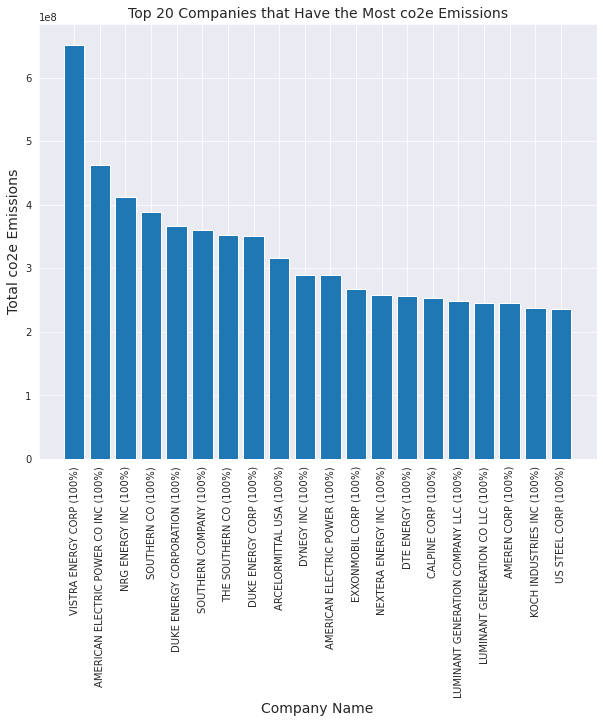

In [16]:
# sum of co2e emission groupby company
company_bar = (gas_facilities_naics
               .groupby('parent_company')
               .agg('sum')['co2e_emission']
               .sort_values(ascending=False)[:20])
plt.figure(figsize=(10,8))
plt.title('Top 20 Companies that Have the Most co2e Emissions',fontsize=14)
plt.xlabel('Company Name',fontsize=14)
plt.ylabel("Total co2e Emissions",fontsize=14)
plt.bar(company_bar.index,height=company_bar)
plt.xticks(company_bar.index,rotation='vertical');
# plt.savefig('Company co2e histogram.png',bbox_inches = 'tight')

### 3.2 co2e Emissions Groupby Sub-sector

Another important column feature is the NAICS code which, as a thread, gives us understanding of how each sectore produce co2e emissions. Similarly, we grouped the dataframe by `sub_sector`. From the result, it is not surprising to see that the top 5 industries turn out to be Utilities, Oil and Gas Extraction, Pertroleum and Coal Production Manufacturing, Chemical Manufacturing and Paper Manufacturing.

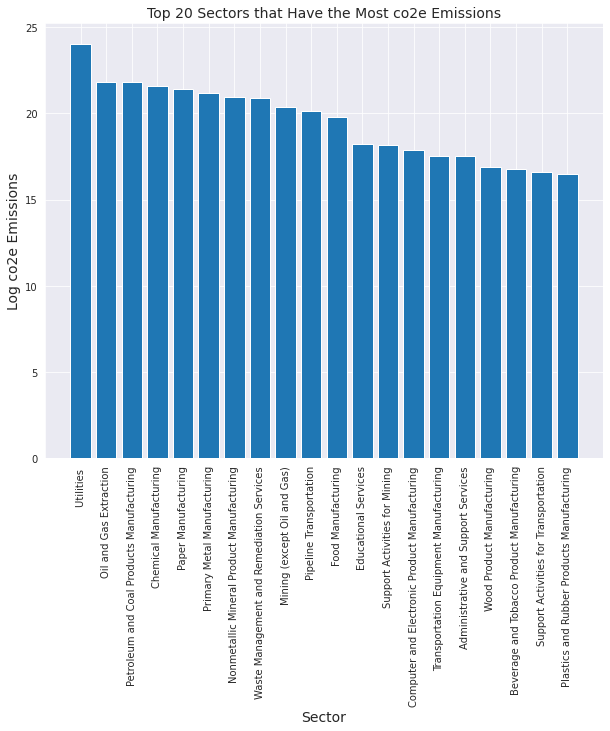

In [17]:
# sum of co2e emission groupby sector
sector_bar = (gas_facilities_naics
              .groupby('naics_title')
              .agg('sum')['co2e_emission']
              .sort_values(ascending=False)[:20])
plt.figure(figsize=(10,8))
plt.title('Top 20 Sectors that Have the Most co2e Emissions',fontsize=14)
plt.xlabel('Sector',fontsize=14)
plt.ylabel("Log co2e Emissions",fontsize=14)
plt.bar(sector_bar.index,height=np.log(sector_bar))
plt.xticks(sector_bar.index,rotation='vertical');
# plt.savefig('Sector log co2e histogram.png',bbox_inches = 'tight')

### 3.3 co2e Emissions Groupby State

Now, let's see how the co2e emissions are distributed geographically. The bar plot shows a one-dimensional comparison of state-level total co2e emissions. It can be noticed that Texas is the most polluted state and its emission almost doubled that of Pennsylvania which ranks at the second place.

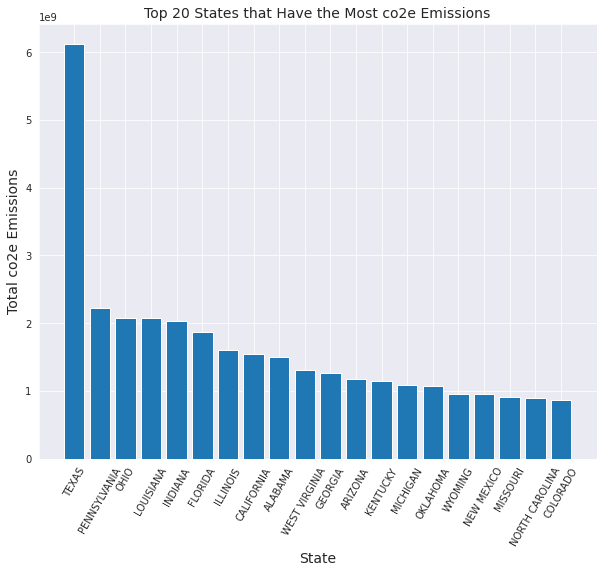

In [18]:
# sum of co2e emission groupby state
state_bar = (gas_facilities_naics
             .groupby('gas_state')
             .agg('sum')['co2e_emission']
             .sort_values(ascending=False)[:20])
plt.figure(figsize=(10,8))
plt.bar(state_bar.index,height=state_bar)
plt.title('Top 20 States that Have the Most co2e Emissions',fontsize=14)
plt.xlabel('State',fontsize=14)
plt.ylabel("Total co2e Emissions",fontsize=14)
plt.xticks(state_bar.index,rotation=60);
# plt.savefig('State co2e histogram.png',bbox_inches = 'tight')

We utilized Census Map as well as GeoPandas to visualize co2e emissions on the map, from which we noticed that the western and southern US states generate more co2e emissions compared to other regions. Specifically, these states are Texas, Pennsylvania, and Ohio.

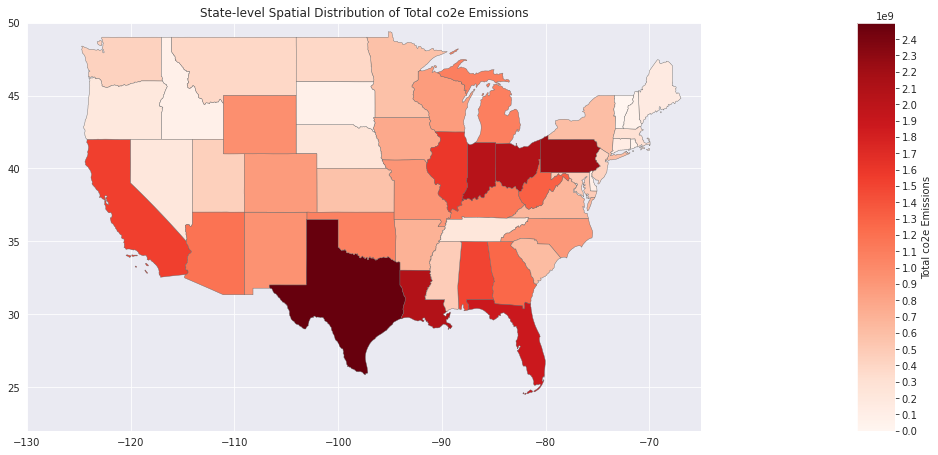

In [20]:
# visualize in maps, shp file downloaded from US Census Bureau
from mpl_toolkits.axes_grid1 import make_axes_locatable
states = gpd.read_file('../data/cb_2018_us_state_20m.shp')
states['NAME'] = states['NAME'].str.upper()
states = states[['NAME','geometry']]
states.head()
state_rank = (gas_facilities_naics
             .groupby('gas_state')
             .agg('sum')['co2e_emission']
             .sort_values(ascending=False))
states_emissions = states.merge(state_rank,left_on = 'NAME',right_on='gas_state')

fig, ax = plt.subplots(1, figsize=(18, 18))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4%", pad="2%")

states_emissions.plot(column='co2e_emission',cmap="Reds",linewidth=0.4,edgecolor=".4",ax=ax,vmin=0, vmax=2500000000,
                      legend_kwds={'label': 'Total co2e Emissions','ticks': np.arange(0,2500000000, 100000000)}, 
                      legend=True,cax=cax)
ax.set_xlim(-130, -65)
ax.set_ylim(22, 50)
ax.set(title="State-level Spatial Distribution of Total co2e Emissions");
# plt.savefig('State Spatial co2e.png')

## Part 4. Data Modeling and Inferences

In the modeling part, we use machine learning to predict the total CO<sub>2</sub> emission through time. As has explored in the EDA part, there is no regular relationship between total carbon dioxide emissions and time, but it has a lot to do with the region (state) the company is located in and the industry of the company. We will use the three features of time, state and industry to build a linear regression model to predict the total carbon dioxide emissions as closely as possible.

There's not enough features so no hyperparameter like the regularization is needed. The feature engineering part would focus on transforming the text values into numeric values.

<h4>4.1 Training-test split

In [ ]:
from sklearn.model_selection import train_test_split
model_data = gas_facilities_naics.copy()
model_data = model_data[model_data["naics_title"] != "Administration of Environmental Quality Programs "]
model_data = model_data[model_data["naics_title"] != "Management of Companies and Enterprises"]
tr, te = train_test_split(model_data, test_size=0.2, random_state=42)

<h4> 4.2 Feature Engineering

We choose the state and the industry(naics_title) as our features here. In the feature engineering process below we add two colums representing the "contribution" of the state/industry to the total CO<sub>2</sub> emission. The contribution scores are calculated as the state/industry’s CO2 emissions as a percentage of total emissions.

We also tried to One Hot Encoding the `gas_type` column, but it turns out that the model with this additional feature performs worse than the model without it. This can been seen from the EDA that the gas tyoe does not influent the emission much.

In [ ]:
# feature engineering 1: OHE gas type
def OHE_gas_type(df):
    from sklearn.preprocessing import OneHotEncoder
    oh_enc = OneHotEncoder()
    oh_enc.fit(df[['gas_code']])
    dummies = pd.DataFrame(oh_enc.transform(df[['gas_code']]).todense(), 
                           columns=oh_enc.get_feature_names(),
                           index = df.index)
    return df.join(dummies)

# feature engineering 2: add contribution score
def add_contribution_score(df):
    # state contribution
    state_contribution = df.groupby("gas_state").sum()[["co2e_emission"]]
    state_contribution["total_emission"] = sum(state_contribution["co2e_emission"])
    state_contribution["state_contribution_score"] = ((state_contribution["co2e_emission"]/state_contribution["total_emission"]*100)).round(2)
    state_contribution = state_contribution.reset_index()

    with_state = df.merge(state_contribution[["gas_state", "state_contribution_score"]], on="gas_state", how="outer")

    # industry contribution
    ind_contribution = df.groupby("naics_title").sum()[["co2e_emission"]]
    ind_contribution["total_emission"] = sum(ind_contribution["co2e_emission"])
    ind_contribution["ind_contribution_score"] = ((ind_contribution["co2e_emission"]/ind_contribution["total_emission"]*100)).round(2)
    ind_contribution = ind_contribution.reset_index()

    with_both = with_state.merge(ind_contribution[["naics_title", "ind_contribution_score"]], on="naics_title", how="inner")
    
    return with_both

# feature engineering 3: OHE state
def OHE_state(df):
    from sklearn.preprocessing import OneHotEncoder
    oh_enc = OneHotEncoder()
    oh_enc.fit(df[['gas_state']])
    dummies = pd.DataFrame(oh_enc.transform(df[['gas_state']]).todense(), 
                           columns=oh_enc.get_feature_names(),
                           index = df.index)
    return df.join(dummies)

# feature engineering 4: OHE industry
def OHE_industry(df):
    from sklearn.preprocessing import OneHotEncoder
    oh_enc = OneHotEncoder()
    oh_enc.fit(df[['naics_title']])
    dummies = pd.DataFrame(oh_enc.transform(df[['naics_title']]).todense(), 
                           columns=oh_enc.get_feature_names(),
                           index = df.index)
    return df.join(dummies)

In [ ]:
# build design matrix with three possible models:
# 1: using contribution score (of state and industry) and OHE gas type
# 2: use only contribution score (of state and industry)
# 3: use OHE state and OHE industry

def fe1(df):
    # return the design metrix and Y of df
    # the design metrix has OHE gas type and contribution scores
    df = add_contribution_score(OHE_gas_type(df))
    return df[["gas_year"]].join(df.iloc[:, 13:]), df["co2e_emission"]

def fe2(df):
    # return the design metrix and Y of df
    # the design metrix has only contribution scores 
    df = add_contribution_score(df)
    return df[["gas_year", "state_contribution_score", "ind_contribution_score"]], df["co2e_emission"]

def fe3(df):
    # return the design metrix and Y of df
    # the design metrix has only OHE state and OHE industry
    df = OHE_state(OHE_industry(df))
    return df[["gas_year"]].join(df.iloc[:, 13:]), df["co2e_emission"]

In [ ]:
# The first model
tr_X_model1, tr_y_model1 = fe1(tr)
te_X_model1, te_y_model1 = fe1(te)
# The second model
tr_X_model2, tr_y_model2 = fe2(tr)
te_X_model2, te_y_model2 = fe2(te)
# The third model
tr_X_model3, tr_y_model3 = fe3(tr)
te_X_model3, te_y_model3 = fe3(te)

<h4> 4.3 Using Linear Regression Model

In [ ]:
tr_X_model3.columns[~tr_X_model3.columns.isin(te_X_model3.columns)]

In [ ]:
from sklearn.linear_model import LinearRegression

# fit model1
tr_model1 = tr.copy()
te_model1 = te.copy()
model1 = LinearRegression()
model1.fit(tr_X_model1, tr_y_model1)

tr_model1["predicted_co2e"] = model1.predict(tr_X_model1)
te_model1["predicted_co2e"] = model1.predict(te_X_model1)

# fit model2
tr_model2 = tr.copy()
te_model2 = te.copy()
model2 = LinearRegression()
model2.fit(tr_X_model2, tr_y_model2)

tr_model2["predicted_co2e"] = model2.predict(tr_X_model2)
te_model2["predicted_co2e"] = model2.predict(te_X_model2)

# fit model3
tr_model3 = tr.copy()
te_model3 = te.copy()
model3 = LinearRegression()
model3.fit(tr_X_model3, tr_y_model3)

tr_model3["predicted_co2e"] = model3.predict(tr_X_model3)
te_model3["predicted_co2e"] = model3.predict(te_X_model3)

<h4> 4.5 Model Evaluation

In [ ]:
# model evaluate methods
from sklearn.metrics import mean_squared_error, mean_absolute_error
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

def plot_y_vs_yhat(df, y, yhat):
    plt.figure(figsize=(9,6))
    Y, Yhat = df[y], df[yhat]
    plt.scatter(Yhat, Y, label='(yhat, y)')
    cmin, cmax = max(Yhat.min(), Y.min()), min(Yhat.max(), Y.max())
    plt.plot([cmin, cmax], [cmin, cmax], color='red', label='y=yhat')
    plt.legend()    
    plt.xlabel("Predicted CO2e Emission",fontsize=14)
    plt.ylabel("True CO2e Emission",fontsize=14)
    plt.title("Y v.s Yhat",fontsize=14)
    plt.savefig('1.png')
    
def plot_predictions(df, x, y, yhat):
    plt.figure(figsize=(9,6))
    X, Y, Yhat = df[x], df[y], df[yhat]
    plt.plot(X, Y, label='ground truth')
    plt.plot(X, Yhat, label='prediction')
    plt.legend()
    plt.xlabel("Year",fontsize=14)
    plt.ylabel("CO2e Emission",fontsize=14)
    plt.title("Sum CO2e Emission As A Function of Year",fontsize=14)
    plt.savefig('2.png')
    
def plot_predictions_over_year(df, x, y, yhat):
    year = df.groupby(by='gas_year').agg('sum').reset_index()
    plot_predictions(year, x, y, yhat)

def evaluate(df, model_name, y, yhat): 
    """Compute and print error metrics"""
    Y, Yhat = df[y], df[yhat]
    metrics = {
        'MSE': mean_squared_error(Y, Yhat),
        'RMSE': np.sqrt(mean_squared_error(Y, Yhat)),
    }
    print(color.BOLD + model_name + color.END)
    for metric, value in metrics.items():
        print(f"{metric}: {value}")
    return metrics

def evaluate_and_plot(df, model_name, x, y, yhat):
    """Report error metrics and also visualize"""
    evaluate(df, model_name, y, yhat)
    plot_y_vs_yhat(df.sample(frac=0.01), y, yhat)
    plot_predictions_over_year(df, x, y, yhat)
    
def evaluate_only(df, model_name, y, yhat): 
    """print error metrics without return"""
    Y, Yhat = df[y], df[yhat]
    metrics = {
        'MSE': mean_squared_error(Y, Yhat),
        'RMSE': np.sqrt(mean_squared_error(Y, Yhat)),
    }
    print(color.BOLD + model_name + color.END)
    for metric, value in metrics.items():
        print(f"{metric}: {value}")

In [ ]:
# model1 training set evaluation
evaluate_and_plot(tr_model1,"Evaluation of Model1 Training Set: State and Industry Contribution Score + OHE Gas Type ",
                  x="gas_year", y='co2e_emission', yhat="predicted_co2e" )

In [ ]:
# model2 training set evaluation
evaluate_and_plot(tr_model2, "Evaluation Of Model2 Training Set: State and Industry Contribution Score",
                 x="gas_year", y='co2e_emission', yhat="predicted_co2e" )

In [ ]:
# model3 training set evaluation
evaluate_and_plot(tr_model3, "Evaluation Of Model3 Training Set: OHE State and Industry",
                 x="gas_year", y='co2e_emission', yhat="predicted_co2e"  )

In [ ]:
# Testing set evaluation
evaluate_only(te_model1, "Model1 Testing Set Evaluation", y='co2e_emission', yhat="predicted_co2e")
evaluate_only(te_model2, "Model2 Testing Set Evaluation", y='co2e_emission', yhat="predicted_co2e")
evaluate_only(te_model3, "Model3 Testing Set Evaluation", y='co2e_emission', yhat="predicted_co2e")

<h4> 4.6 Comment

From the evaluations above, it's clear the performance of model3 is the best. This indicates that when trying to predict total emission of CO<sub>2</sub>, given our limited features, using year, state and industry can yeild a relatively decent result, while gas type makes no contribution to our model.<br>
Comparing the evaluation result of the traning set and testing set, obviously no overfitting happens:

|   |RMSE|RMSE in le7|Difference Rate|
|---|---|---|---|
|Model1 Training Set|880098|0.088|   |
|__Model1 Testing Set__|__903774__|__0.090__|__2.7%__|
|Model2 Training Set|856929|0.086|   |
|__Model2 Testing Set__|__882722__|__0.088__|__3.0%__|
|Model3 Training Set|822155|0.082|   |
|__Model3 Testing Set__|__846932__|__0.085__|__-4.0%__|

So there's no need to perform cross vadidation or regularization on our model.

Another thing to notice is that, even our best performed model here is not a perfect predictor of the fluctuation of carbon dioxide emissions over time. This is because the emission of all pollutants including carbon dioxide is greatly affected by national policies and national economic levels. For example, the leap in emissions from 2010 to 2011 is largely due to the fact that it took the United States almost three years to recover from the 2008 economic crisis; and the drop started from 2015 may be a result of the Paris Climate Accords.<br>